In [2]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import cv2

In [3]:
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

In [4]:
import os

# Function to extract file paths and labels, skipping hidden files like .DS_Store
def extract_filepaths_and_labels(data_dir):
    filepaths = []
    labels = []
    classes = os.listdir(data_dir)  # List all class folders
    for class_name in classes:
        class_path = os.path.join(data_dir, class_name)
        
        # Skip hidden files like .DS_Store and process only directories
        if not class_name.startswith('.') and os.path.isdir(class_path):
            for file in os.listdir(class_path):
                file_path = os.path.join(class_path, file)
                
                # Skip hidden files in the subdirectories as well
                if not file.startswith('.'):
                    filepaths.append(file_path)
                    labels.append(class_name)  # Use class name as label
    return filepaths, labels

# Define the dataset directory paths
train_data_dir = "./dataset/training/"
test_data_dir = "./dataset/testing/"

# Extract training file paths and labels
train_filepaths, train_labels = extract_filepaths_and_labels(train_data_dir)

# Extract testing file paths and labels
test_filepaths, test_labels = extract_filepaths_and_labels(test_data_dir)

# Optionally, you can print sample outputs to verify
print("Sample training file paths and labels:")
for i in range(5):  # Print the first 5 training file paths and labels
    print(f"File: {train_filepaths[i]}, Label: {train_labels[i]}")

print("\nSample testing file paths and labels:")
for i in range(5):  # Print the first 5 testing file paths and labels
    print(f"File: {test_filepaths[i]}, Label: {test_labels[i]}")

Sample training file paths and labels:
File: ./dataset/training/pituitary/Tr-pi_0505.jpg, Label: pituitary
File: ./dataset/training/pituitary/Tr-pi_0263.jpg, Label: pituitary
File: ./dataset/training/pituitary/Tr-pi_0277.jpg, Label: pituitary
File: ./dataset/training/pituitary/Tr-pi_1169.jpg, Label: pituitary
File: ./dataset/training/pituitary/Tr-pi_0511.jpg, Label: pituitary

Sample testing file paths and labels:
File: ./dataset/testing/pituitary/Te-pi_0233.jpg, Label: pituitary
File: ./dataset/testing/pituitary/Te-pi_0227.jpg, Label: pituitary
File: ./dataset/testing/pituitary/Te-pi_0019.jpg, Label: pituitary
File: ./dataset/testing/pituitary/Te-pi_0031.jpg, Label: pituitary
File: ./dataset/testing/pituitary/Te-pi_0025.jpg, Label: pituitary


In [6]:
# List all classes (subdirectories) in the training directory
train_data_dir = "./dataset/training/"
classes = os.listdir(train_data_dir)

classes.remove(".DS_Store")
print(classes)

['pituitary', 'notumor', 'glioma', 'meningioma']


In [7]:
import pandas as pd

# Concatenate training data paths with labels into one dataframe
Fseries_train = pd.Series(train_filepaths, name="filepaths")
Lseries_train = pd.Series(train_labels, name="labels")
train_df = pd.concat([Fseries_train, Lseries_train], axis=1)

# Concatenate testing data paths with labels into one dataframe
Fseries_test = pd.Series(test_filepaths, name="filepaths")
Lseries_test = pd.Series(test_labels, name="labels")
test_df = pd.concat([Fseries_test, Lseries_test], axis=1)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# crobed image size
batch_size = 12
img_size = (224,224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

In [9]:
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


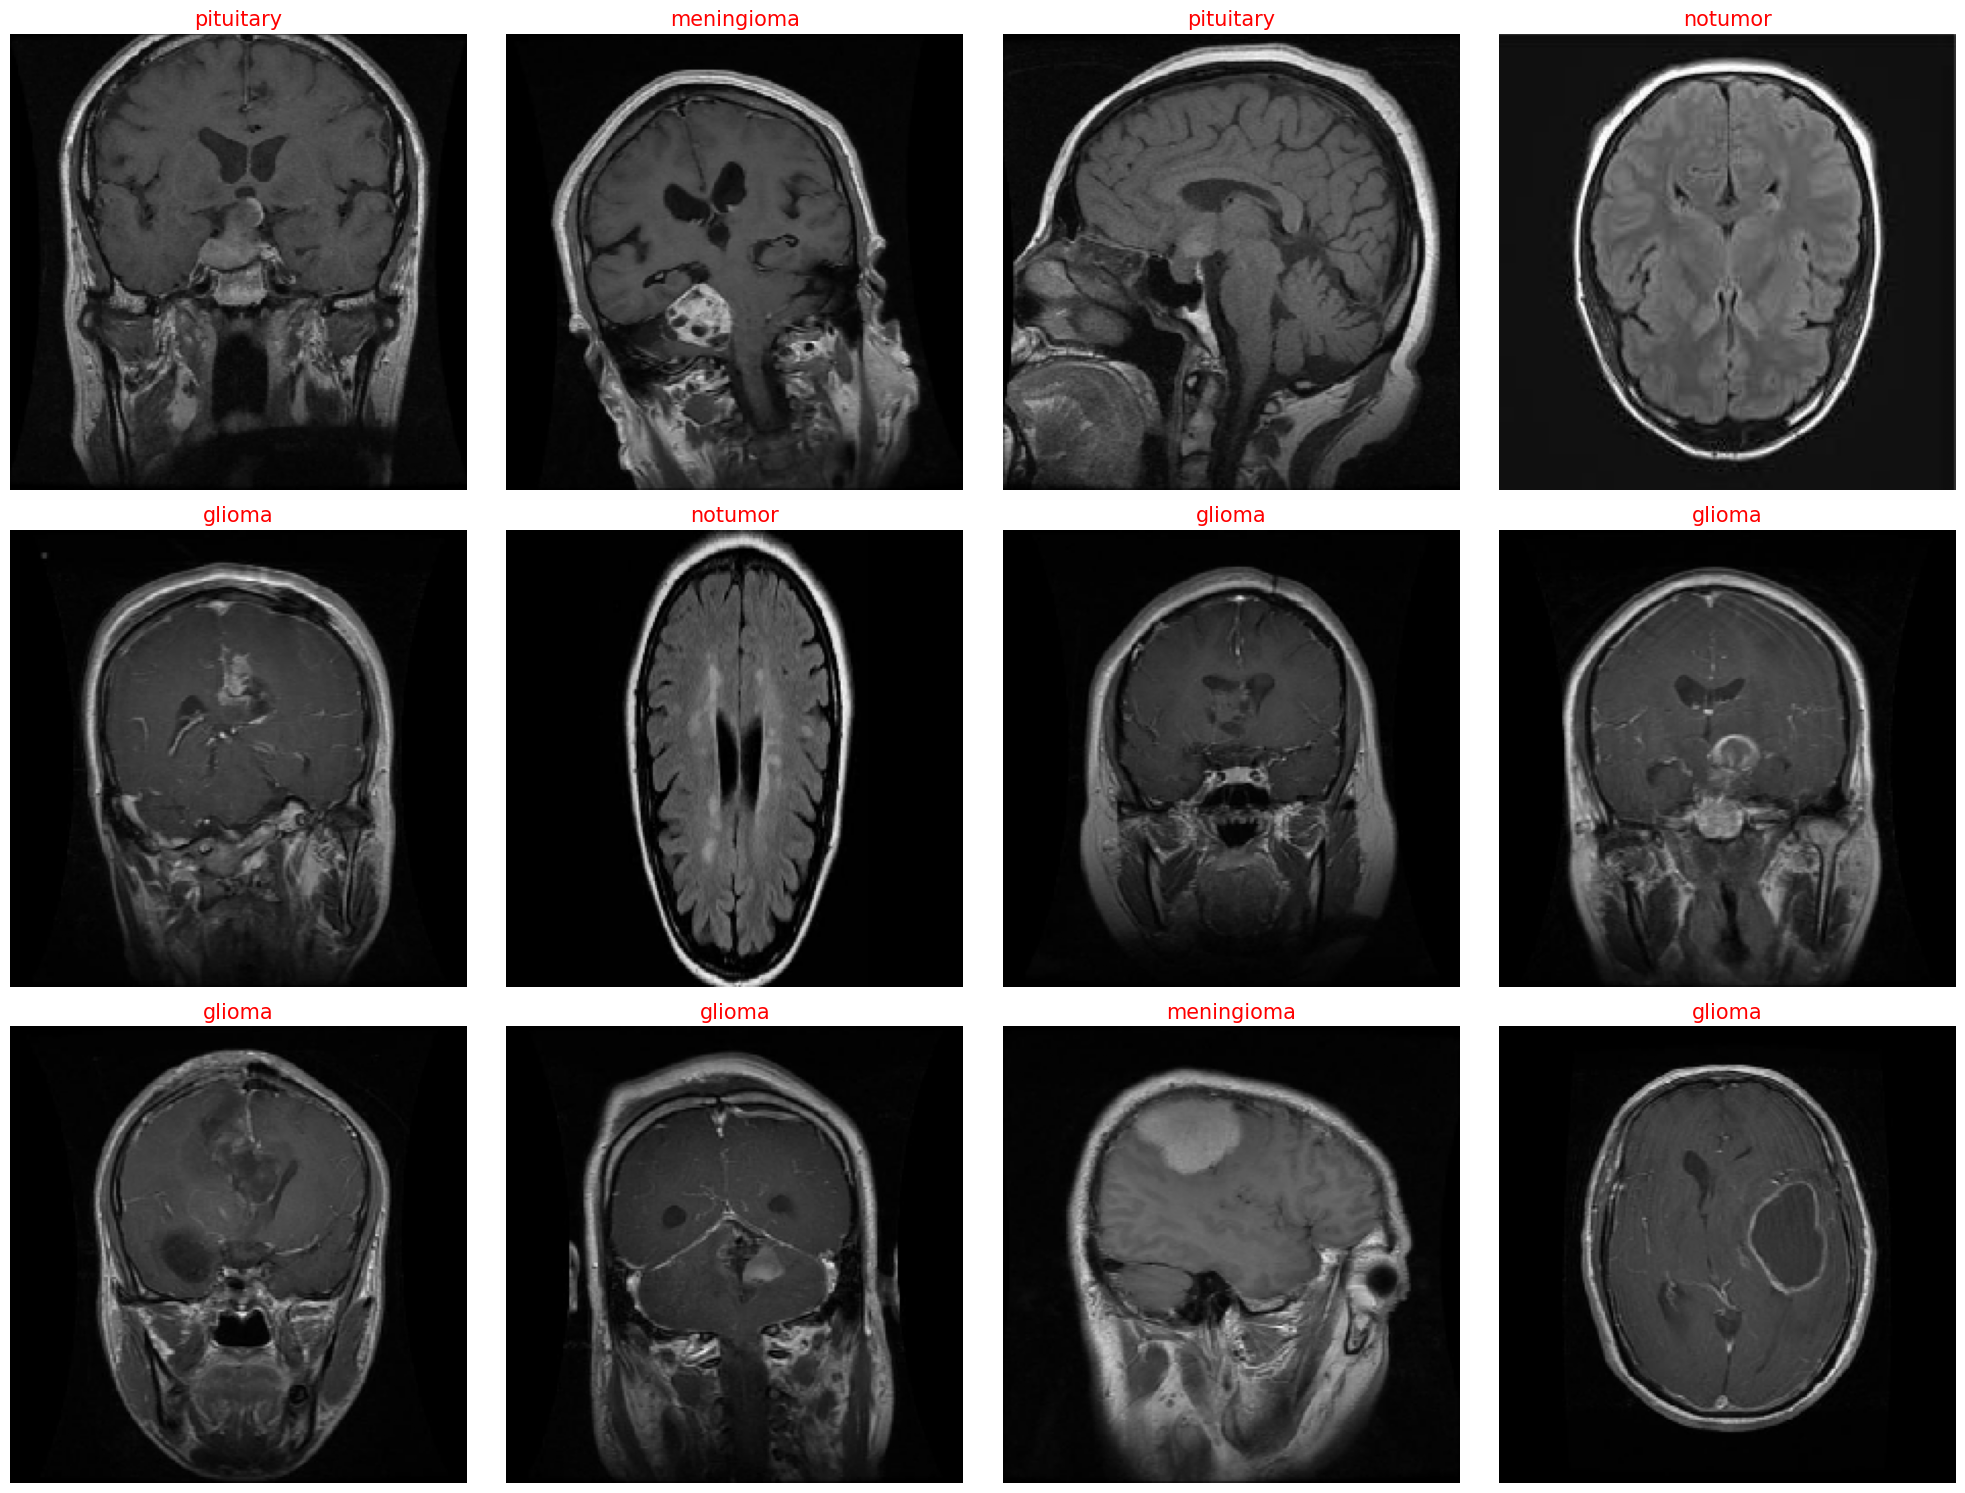

In [10]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())         # defines list of dictionary's keys (class names)
images, labels = next(train_gen)      # get a batch of samples from the generator

plt.figure(figsize=(20, 20))

# Get the actual number of images in the batch
num_images = len(images)
num_to_display = min(16, num_images)  # Display up to 16 images or fewer if not enough

for i in range(num_to_display):
    plt.subplot(4, 4, i+1)
    image = images[i] / 255.0         # scales data to range (0 - 1)
    plt.imshow(image)
    
    index = np.argmax(labels[i])      # get the index of the class with the highest probability
    class_name = classes[index]       # get the class name corresponding to the index
    plt.title(class_name, color='red', fontsize=15)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [11]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) 

In [13]:

# Build AlexNet model
model = Sequential([
    # First Convolutional Layer
    Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=img_shape),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    BatchNormalization(),

    # Second Convolutional Layer
    Conv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    BatchNormalization(),

    # Third Convolutional Layer
    Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'),
    
    # Fourth Convolutional Layer
    Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'),
    
    # Fifth Convolutional Layer
    Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    
    # Flatten for Fully Connected Layers
    Flatten(),
    
    # First Fully Connected Layer
    Dense(4096, activation='relu'),
    Dropout(0.5),
    
    # Second Fully Connected Layer
    Dense(4096, activation='relu'),
    Dropout(0.5),
    
    # Output Layer
    Dense(class_count, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

/opt/anaconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-01 23:44:31.835878: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2024-11-01 23:44:31.835899: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-11-01 23:44:31.835903: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-11-01 23:44:31.835916: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-01 23:44:31.835927: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Creat

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    26,218,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │        16,388 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,764,804 (178.39 MB)

 Trainable params: 46,764,100 (178.39 MB)

 Non-trainable params: 704 (2.75 KB)

In [22]:
import tensorflow as tf

epochs = 10   
history = model.fit(x= train_gen, epochs= epochs, verbose= 1, shuffle= False)

Epoch 1/10


2024-11-01 23:45:05.503788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/opt/anaconda3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


476/476 ━━━━━━━━━━━━━━━━━━━━ 54s 112ms/step - accuracy: 0.6397 - loss: 0.8963
Epoch 2/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 54s 113ms/step - accuracy: 0.8238 - loss: 0.4573
Epoch 3/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 54s 113ms/step - accuracy: 0.8749 - loss: 0.3272
Epoch 4/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 63s 131ms/step - accuracy: 0.9172 - loss: 0.2333
Epoch 5/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 66s 138ms/step - accuracy: 0.9456 - loss: 0.1565
Epoch 6/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 63s 132ms/step - accuracy: 0.9611 - loss: 0.1109
Epoch 7/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 63s 132ms/step - accuracy: 0.9715 - loss: 0.0847
Epoch 8/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 66s 138ms/step - accuracy: 0.9851 - loss: 0.0465
Epoch 9/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 66s 139ms/step - accuracy: 0.9904 - loss: 0.0335
Epoch 10/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 65s 137ms/step - accuracy: 0.9906 - loss: 0.0243


In [23]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
index_loss = np.argmin(tr_loss)
lowest_loss = tr_loss[index_loss]
index_acc = np.argmax(tr_acc)
highest_acc = tr_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

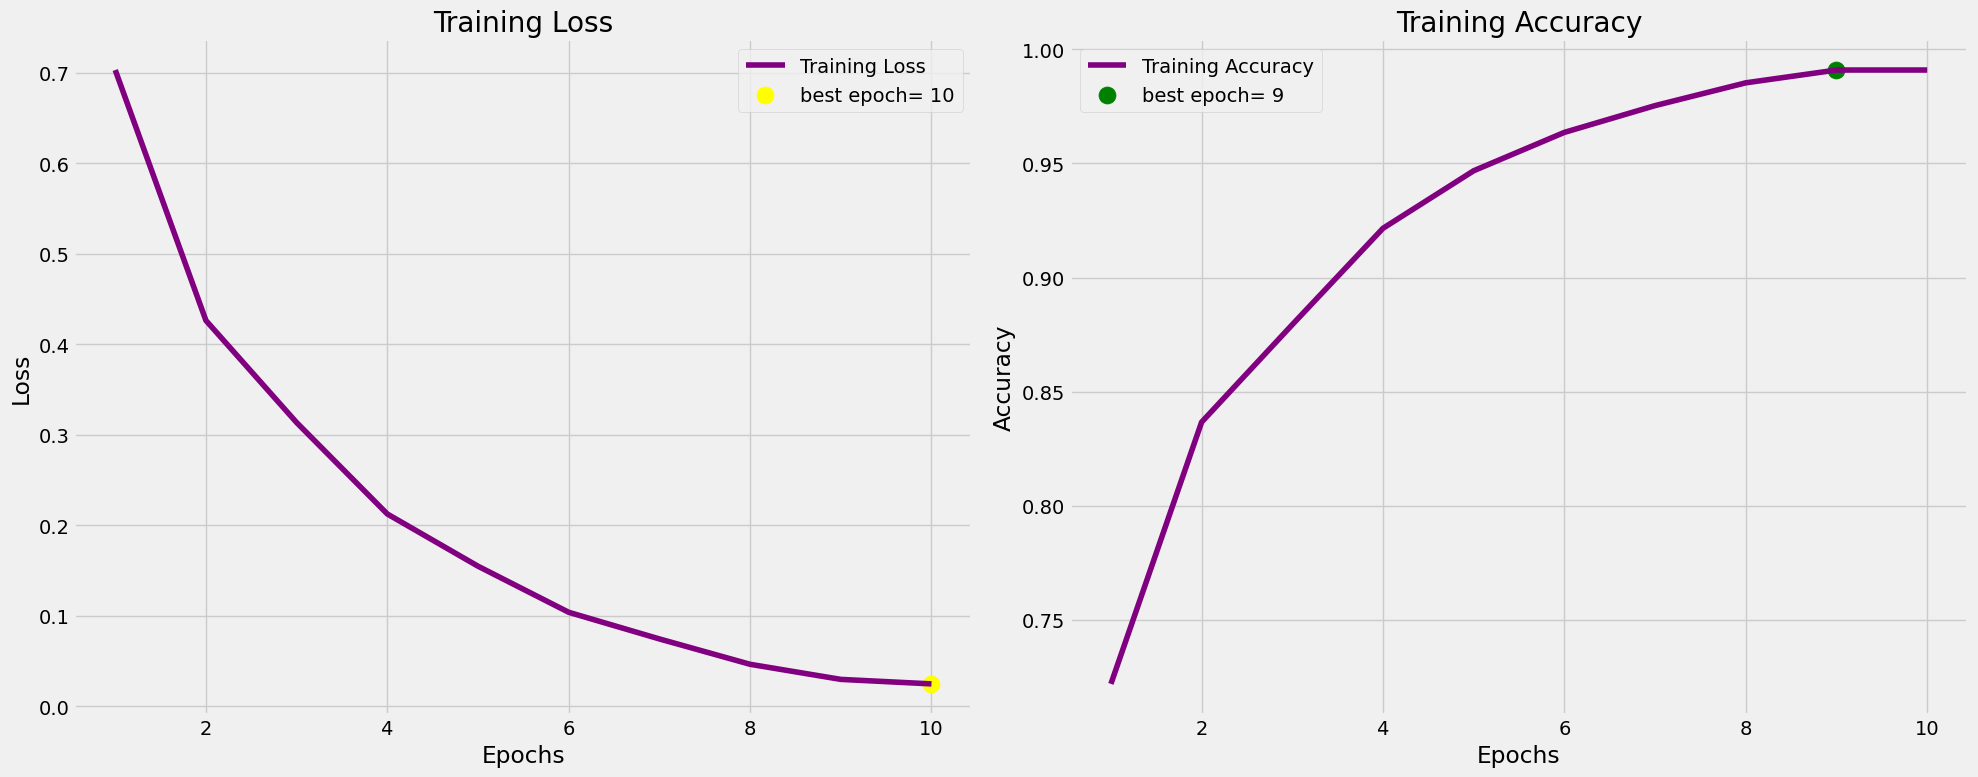

In [45]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'purple', label='Training Loss')
plt.scatter(index_loss + 1, lowest_loss, s=150, c='yellow', label=loss_label)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'purple', label='Training Accuracy')
plt.scatter(index_acc + 1, highest_acc, s=150, c='green', label=acc_label)
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
train_score = model.evaluate(train_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

476/476 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.9969 - loss: 0.0150
  7/110 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9691 - loss: 0.0543

/opt/anaconda3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9799 - loss: 0.0591
Train Loss:  0.014977904967963696
Train Accuracy:  0.9959734082221985
--------------------
Test Loss:  0.12472758442163467
Test Accuracy:  0.9580472707748413


In [26]:
pred = model.predict(test_gen)    # [[0.001, 0.97, 0.01, 0.009], [], [], ]
y_pred = np.argmax(pred, axis=1)

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


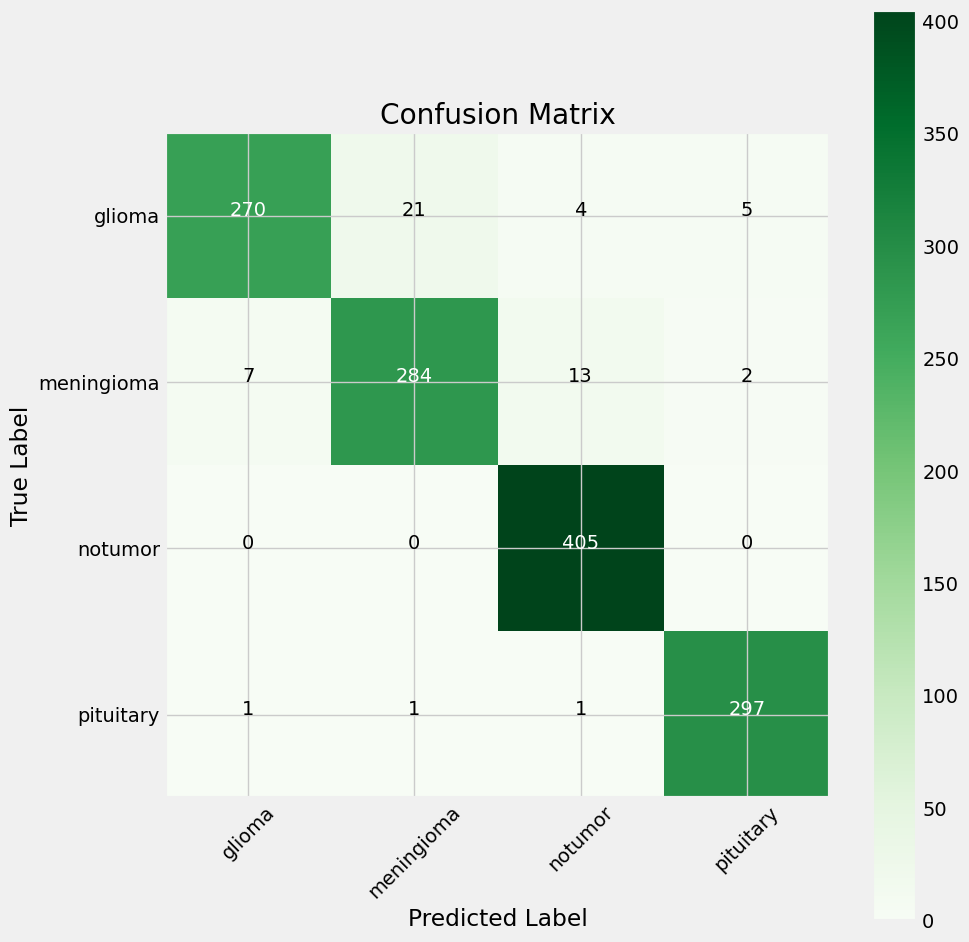

In [27]:
from sklearn.metrics import confusion_matrix
import itertools

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Greens)
plt.title('Confusion Matrix')
plt.colorbar()


tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [33]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       0.97      0.90      0.93       300
  meningioma       0.93      0.93      0.93       306
     notumor       0.96      1.00      0.98       405
   pituitary       0.98      0.99      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.95      0.96      1311
weighted avg       0.96      0.96      0.96      1311



In [39]:
# Save the model
model.save('./models/Brain_Tumors_alex.h5')

# Load the model with the correct file path
loaded_model = tf.keras.models.load_model('./models/Brain_Tumors_alex.h5', compile=False)
loaded_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

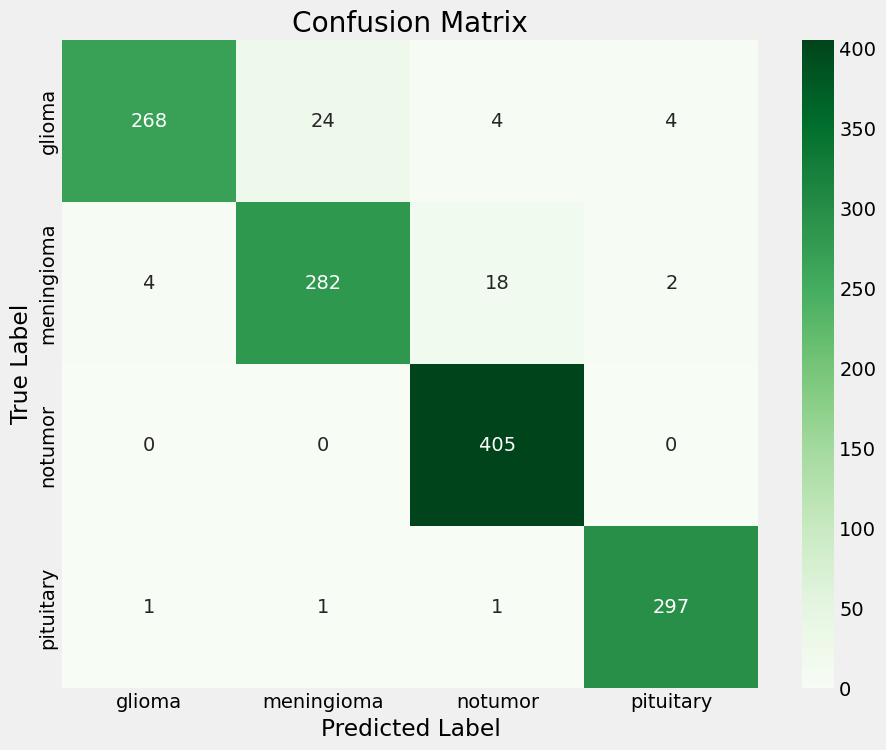

In [41]:
import os
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Set the path to the test directory
test_dir = "./dataset/testing/"

# List of class labels (modify based on your model's output)
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Variables to calculate accuracy and confusion matrix
correct_predictions = 0
total_images = 0
true_labels = []
predicted_labels = []

# Iterate over subdirectories and images
for subdir, dirs, files in os.walk(test_dir):
    for file in files:
        # Skip non-image files if any
        if file.endswith(('.jpg', '.jpeg', '.png')):
            total_images += 1
            image_path = os.path.join(subdir, file)

            # Get the true class label from the subdirectory name
            true_class = os.path.basename(subdir).lower().strip()  # Convert to lowercase and strip spaces

            # Append the true label (convert to class index for confusion matrix)
            if true_class in class_labels:
                true_labels.append(class_labels.index(true_class))
            else:
                print(f"Warning: '{true_class}' not found in class_labels.")
                continue

            # Load and preprocess the image
            image = Image.open(image_path).convert("RGB")  # Convert to RGB to ensure 3 channels
            img = image.resize((224, 224))  # Resize image to fit model input
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

            # Make predictions
            predictions = loaded_model.predict(img_array)

            # Get predicted class label
            predicted_class = class_labels[np.argmax(predictions)]

            # Append predicted label (convert to class index for confusion matrix)
            predicted_labels.append(np.argmax(predictions))

            # Print the file name, predicted class, and true class
            #print(f"Image: {file} - Predicted class: {predicted_class} - True class: {true_class}")

            # Check if the prediction is correct
            if predicted_class == true_class:
                correct_predictions += 1

# Calculate accuracy
accuracy = correct_predictions / total_images * 100
print(f"Accuracy: {accuracy:.2f}%")

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()